# Evolutionary optimization of a whole-brain model

This notebook provides an example for the use of the evolutionary optimization framework built-in to the library. Under the hood, the implementation of the evolutionary algorithm is powered by `deap` and `pypet` cares about the parallelization and storage of the simulation data for us.

We want to optimize a whole-brain network that should produce simulated BOLD activity (fMRI data) that is similar to the empirical dataset. We measure the fitness of each simulation by computing the `func.matrix_correlation` of the functional connectivity `func.fc(model.BOLD.BOLD)` to the empirical data `ds.FCs`. The ones that are closest to the empirical data get a higher fitness and have a higher chance of reproducing and survival. 

In [ ]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [4]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    
import numpy as np
import logging 

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func

from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

We create a brain network model using the empirical dataset `ds`:

In [12]:
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
model.params['sigma_ou'] = 0.09
model.params['b'] = 5.0
model.params['signalV'] = 2
model.params['dt'] = 0.2
model.params['duration'] = 0.2 * 60 * 1000 #ms
# testing: aln.params['duration'] = 0.2 * 60 * 1000 #ms
# real: aln.params['duration'] = 1.0 * 60 * 1000 #ms

Our evaluation function will do the following: first it will simulate the model for a short time to see whether there is any sufficient activity. This speeds up the evolution considerably, since large regions of the state space show almost no neuronal activity. Only then do we simulate the model for the full duration and compute the fitness using the empirical dataset.

In [1]:
def evaluateSimulation(traj):
    rid = traj.id
    model = evolution.getModelFromTraj(traj)
    defaultDuration = model.params['duration']
    invalid_result = (np.nan,)* len(ds.BOLDs)
    
    # -------- stage wise simulation --------
    
    # Stage 1 : simulate for a few seconds to see if there is any activity
    # ---------------------------------------
    model.params['duration'] = 3*1000.
    model.run()
    
    # check if stage 1 was successful
    if np.max(model.output[:, model.t > 500]) > 160 or np.max(model.output[:, model.t > 500]) < 10:
        return invalid_result, {}

    
    # Stage 2: full and final simulation
    # ---------------------------------------
    model.params['duration'] = defaultDuration
    model.run(chunkwise=True, bold = True)
    
    # -------- fitness evaluation here --------
    
    scores = []
    for i, fc in enumerate(ds.FCs):#range(len(ds.FCs)):
        fc_score = func.matrix_correlation(func.fc(model.BOLD.BOLD[:, 5:]), fc)
        scores.append(fc_score)
    
    meanFitness = np.mean(scores)
    fitness_tuple = (meanFitness,)
    #print(f"fitness {meanFitness}")
    #print(f"scores {scores}")
    
    fitness_tuple = tuple(scores)
    return fitness_tuple, {}

We specify the parameter space that we want to search.

In [14]:
pars = ParameterSpace(['mue_ext_mean', 'mui_ext_mean', 'b', 'sigma_ou', 'Ke_gl', 'signalV'], 
                      [[0.0, 3.0], [0.0, 3.0], [0.0, 100.0], [0.0, 0.3], [0.0, 500.0], [0.0, 400.0]])

Note that we chose `algorithm='nsga2'` when we create the `Evolution`. This will use the multi-objective optimization algorithm by Deb et al. 2002. Although we have only one objective here (namely the FC fit), we could in principle add more objectives, like the `FCD` matrix fit or other objectives. For this, we would have to add these values to the fitness in the evaluation function above and add more `weights` in the definition of the `Evolution`. We can use positive weights for that objective to be maximized and negative ones for minimization. Please refer to the [DEAP documentation](https://deap.readthedocs.io/) for more information.

In [ ]:
evolution = Evolution(evaluateSimulation, pars, algorithm = 'nsga2', weightList = [1.0] * len(ds.BOLDs), model = model, POP_INIT_SIZE=4, POP_SIZE = 4, NGEN=2, filename="example-2.2.hdf")
#testing: evolution = Evolution(evaluateSimulation, pars, algorithm = 'nsga2', weightList = [1.0] * len(ds.BOLDs), model = model, POP_INIT_SIZE=4, POP_SIZE = 4, NGEN=2)
# real: evolution = Evolution(evaluateSimulation, pars, algorithm = 'nsga2', weightList = [1.0] * len(ds.BOLDs), model = model, POP_INIT_SIZE=1600, POP_SIZE = 160, NGEN=100)

That's it, we can run the evolution now.

In [ ]:
evolution.run(verbose = False)

We could now save the full evolution object for later analysis using `evolution.saveEvolution()`.

# Analysis

The `info()` method gives us a useful overview of the evolution, like a summary of the evolution parameters, the statistics of the population and also scatterplots of the individuals in our search space.

--- Info summary ---
Valid: 160
Mean score (weighted fitness): 0.53
Parameters dictribution (Generation 99):
mue_ext_mean: 	 mean: 0.147,	 std: 0.02449
mui_ext_mean: 	 mean: 0.1343,	 std: 0.05387
b: 	 mean: 93.05,	 std: 5.84
sigma_ou: 	 mean: 0.05296,	 std: 0.01099
Ke_gl: 	 mean: 233.1,	 std: 20.57
signalV: 	 mean: 344.3,	 std: 68.9
--------------------
Best 5 individuals:
Printing 5 individuals
Individual 0 pars mue_ext_mean 0.1557, mui_ext_mean 0.08049, b 96.18, sigma_ou 0.05687, Ke_gl 222.8, signalV 354.9
	Fitness values:  0.5426 0.4137 0.6459 0.5287 0.552 0.7209 0.5181 0.4997 0.42 0.4226 0.4279 0.5029 0.652 0.5667 0.5394 0.5894 0.472 0.6361 0.5217 0.5899 0.6456 0.5204 0.637 0.7114
Individual 1 pars mue_ext_mean 0.172, mui_ext_mean 0.1519, b 83.8, sigma_ou 0.06809, Ke_gl 219.2, signalV 308.3
	Fitness values:  0.5798 0.4495 0.6525 0.4953 0.5876 0.7077 0.5263 0.5381 0.4222 0.4486 0.4347 0.5051 0.6232 0.5411 0.5383 0.5532 0.4716 0.6162 0.5442 0.5476 0.6644 0.5176 0.5826 0.6867
Individu

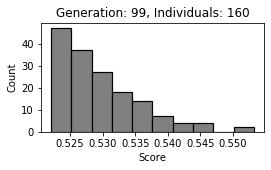

<Figure size 432x288 with 0 Axes>

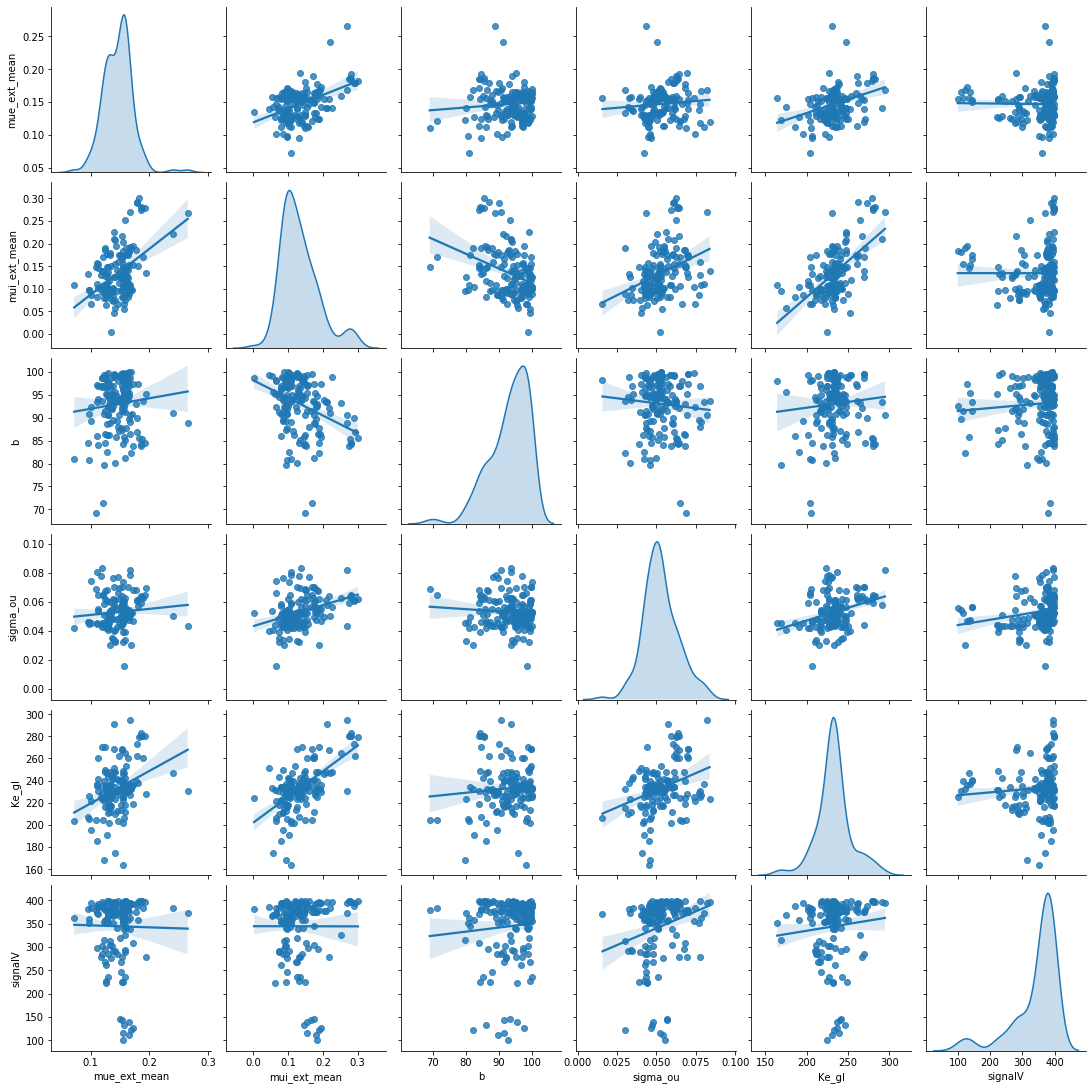

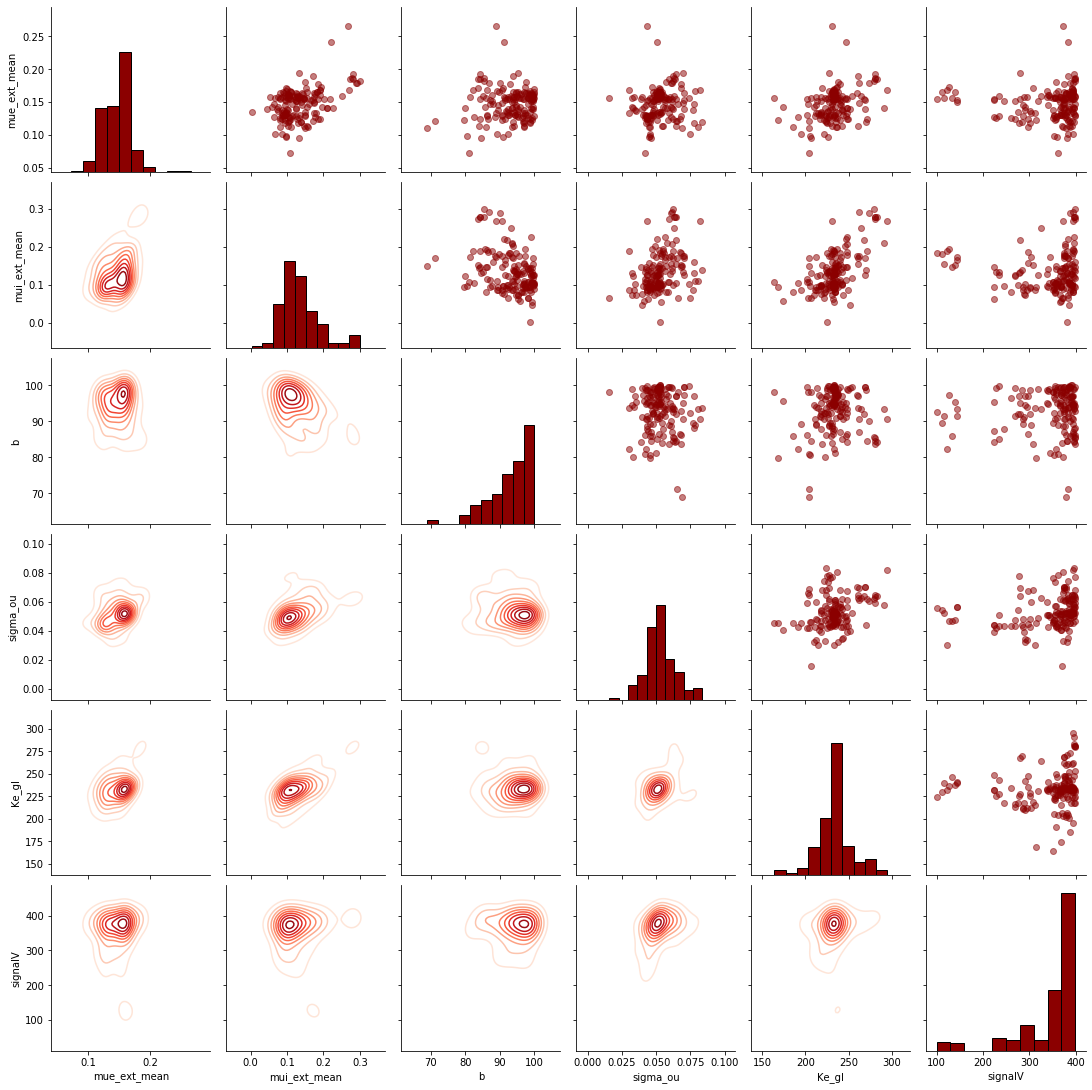

In [17]:
evolution.info()

In [ ]:
# This will load results from disk in case the session is 
# started newly and the trajectory is not in memory
traj = evolution.loadResults()

In [20]:
gens, all_scores = evolution.getScoresDuringEvolution(reverse=True)

Text(0, 0.5, 'Score')

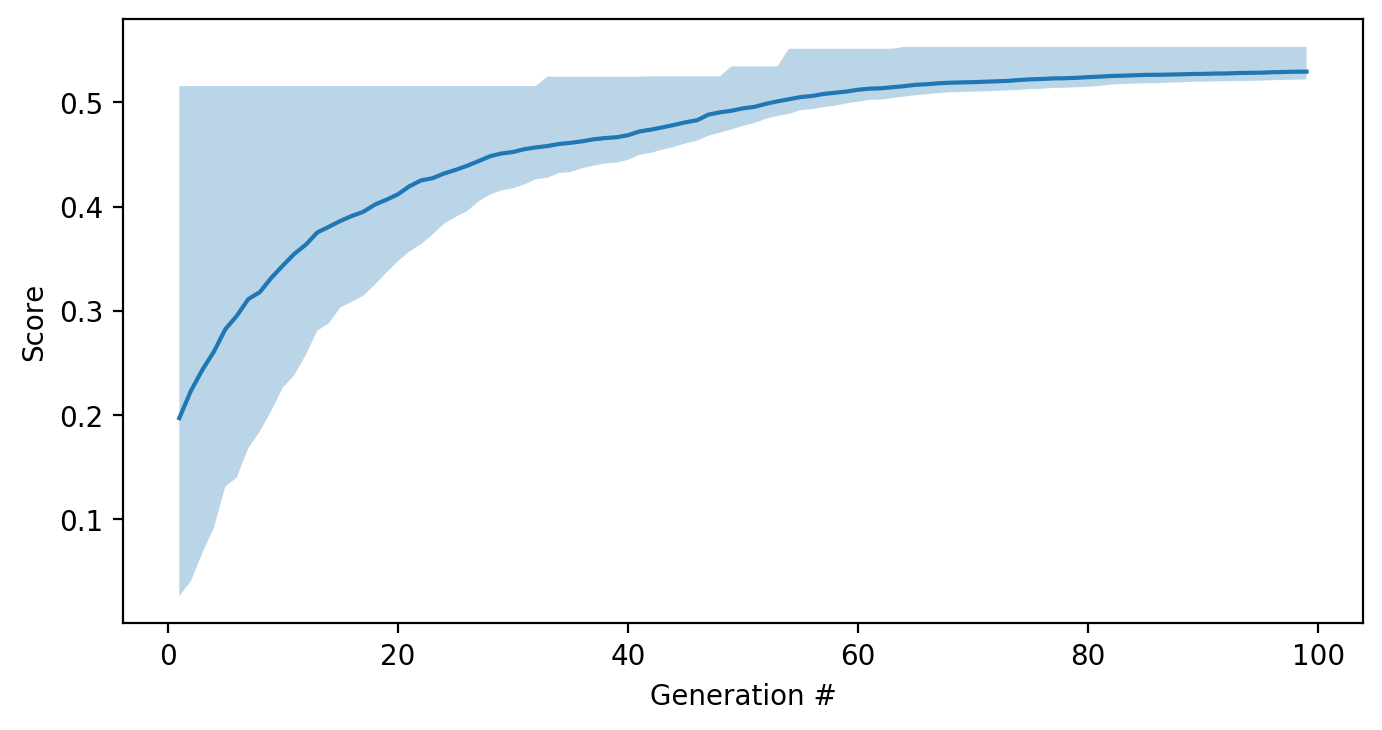

In [21]:
plt.figure(figsize=(8, 4), dpi=200)   
plt.plot(gens, np.nanmean(all_scores, axis=1))
plt.fill_between(gens, np.nanmin(all_scores, axis=1), np.nanmax(all_scores, axis=1), alpha=0.3)
plt.xlabel("Generation #")
plt.ylabel("Score")